# Case Study 5

## Description


Build a classifier to determine whether or not firewall requests should be automated. [source](https://archive.ics.uci.edu/ml/datasets/Internet+Firewall+Data#)

### Attributes

- Source Port
- Destination Port
- NAT Source Port
- NAT Destination Port
- Action
- Bytes
- Bytes Sent,
- Bytes Received
- Packets
- Elapsed Time (sec)
- pkts_sent
- pkts_received 

### Response (Action)

- allow
- action
- drop
- reset-both

### Class Notes

- Try to do all four classes - but they are "horribly" imbalanced (one has very few samples)
- bytes, packets are ordinal (whole integers)
- Ports are in a sense categorical (needs one hot encoded)
    - Can try to group if desired
- Make sure to do random shuffle when splitting/cross validation
- Column E (allow, not allow, etc) is target variable
- Do test/train split instead of cross validation (takes too long)
- Can make a new features out of pkts_sent and pkts_received (maybe the delta?)

## Setup

### Load Libraries

In [59]:
# Import standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import sklearn libraries
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix,plot_roc_curve, auc, roc_curve,confusion_matrix
from sklearn.linear_model import SGDClassifier

# Import other libraries
import os
import warnings
import joblib


# Set options
pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

warnings.filterwarnings("ignore")
get_ipython().run_line_magic("matplotlib", "inline")

[CV 8/10; 1/10] START model__C=100, model__class_weight=balanced, model__gamma=0.001, model__kernel=linear
[CV 8/10; 1/10] END model__C=100, model__class_weight=balanced, model__gamma=0.001, model__kernel=linear;, score=(train=0.998, test=0.997) total time= 2.5min
[CV 5/10; 3/10] START model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly
[CV 5/10; 3/10] END model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly;, score=(train=0.996, test=0.996) total time= 3.2min
[CV 1/10; 4/10] START model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear
[CV 1/10; 4/10] END model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear;, score=(train=0.998, test=0.998) total time= 1.5min
[CV 3/10; 4/10] START model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear
[CV 3/10; 4/10] END model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear;, score=(train=0.998, tes

### Load Data

In [17]:
df = pd.read_csv('log2.csv')

## Exploratory Data Analysis

In [18]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df.tail()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0
65531,54867,445,0,0,drop,70,70,0,1,0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [9]:
df.shape

(65532, 12)

In [4]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [12]:
# Missing values?
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [14]:
df.nunique()

Source Port             22724
Destination Port         3273
NAT Source Port         29152
NAT Destination Port     2533
Action                      4
Bytes                   10724
Bytes Sent               6683
Bytes Received           8814
Packets                  1116
Elapsed Time (sec)        915
pkts_sent                 749
pkts_received             922
dtype: int64

In [15]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [16]:
# Pairwise Correlation
df.corr()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
Source Port,1.000000,-0.332246,0.145391,-0.024843,0.000221,-0.000931,0.001950,-0.001742,-0.046515,-0.001422,-0.001962
Destination Port,-0.332246,1.000000,-0.281676,0.410042,-0.005297,0.001675,-0.014684,-0.006063,0.023537,-0.002134,-0.010909
NAT Source Port,0.145391,-0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772
NAT Destination Port,-0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,-0.003216,0.004605,0.219776,0.006136,0.001747
Bytes,0.000221,-0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209
Bytes Sent,-0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098
Bytes Received,0.001950,-0.014684,0.020827,-0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039
Packets,-0.001742,-0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978
Elapsed Time (sec),-0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954
pkts_sent,-0.001422,-0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550


array([[<AxesSubplot:title={'center':'Source Port'}>,
        <AxesSubplot:title={'center':'Destination Port'}>],
       [<AxesSubplot:title={'center':'NAT Source Port'}>,
        <AxesSubplot:title={'center':'NAT Destination Port'}>],
       [<AxesSubplot:title={'center':'Bytes'}>,
        <AxesSubplot:title={'center':'Bytes Sent'}>],
       [<AxesSubplot:title={'center':'Bytes Received'}>,
        <AxesSubplot:title={'center':'Packets'}>],
       [<AxesSubplot:title={'center':'Elapsed Time (sec)'}>,
        <AxesSubplot:title={'center':'pkts_sent'}>],
       [<AxesSubplot:title={'center':'pkts_received'}>, <AxesSubplot:>]],
      dtype=object)

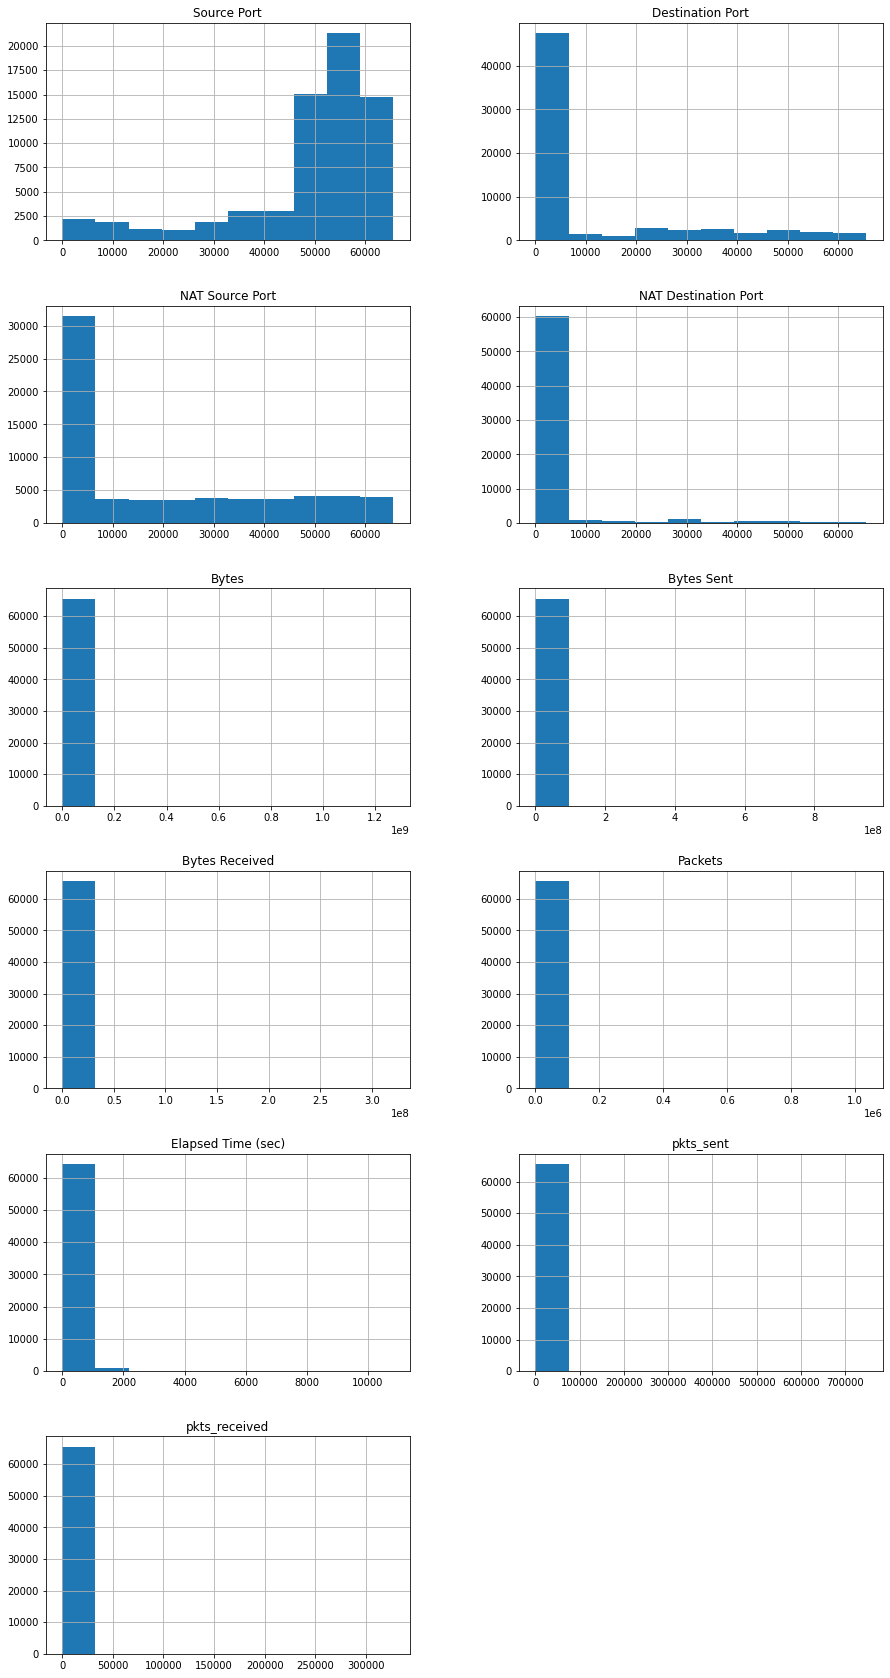

In [23]:
df.hist(figsize = (15, 30), layout = (6, 2))

Text(0, 0.5, 'Count')

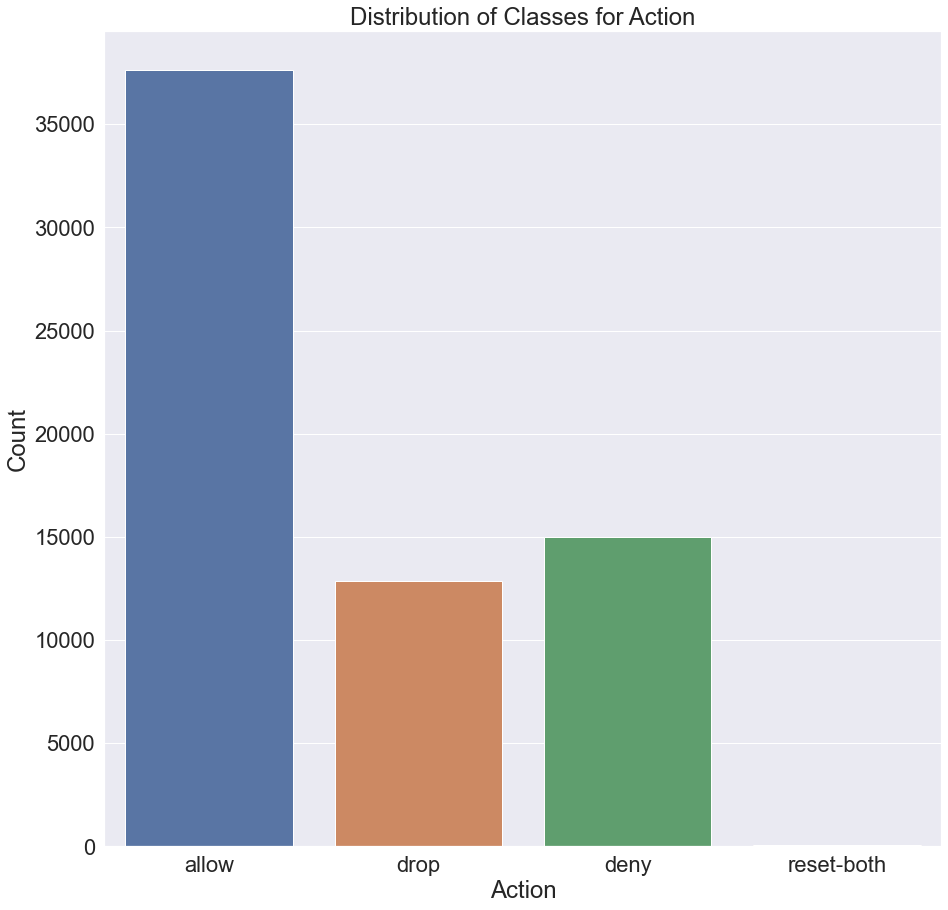

In [28]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.set(font_scale = 2)
p = sns.countplot(df['Action'])
p.set_title('Distribution of Classes for Action')
p.set_ylabel('Count')

In [29]:
# Drop 'reset-both' since it doesn't even register on the bar graph
df = df.loc[df['Action'] != 'reset-both']

In [31]:
print(f"Source Port Unique Levels: {len(df['Source Port'].unique())}")
print(f"Destination Port Unique Levels: {len(df['Destination Port'].unique())}")
print(f"NAT Source Port Unique Levels: {len(df['NAT Source Port'].unique())}")
print(f"NAT Destination Port Unique Levels: {len(df['NAT Destination Port'].unique())}")

Source Port Unique Levels: 22692
Destination Port Unique Levels: 3264
NAT Source Port Unique Levels: 29143
NAT Destination Port Unique Levels: 2533


In [44]:
# Does the source or destination port need NAT?
def nat_needed(num: int) -> int:
    if num == 0:
        return num
    else:
        return 1
    
df['Source Need NAT'] = df['NAT Source Port'].apply(lambda x: nat_needed(x))
df['Destination Need NAT'] = df['NAT Destination Port'].apply(lambda x: nat_needed(x))

df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Need NAT,Destination Need NAT
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,1,1
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,1,1
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,1,1


In [34]:
# Define numeric variables
df_numeric = df[['Bytes','Bytes Received','Packets','Elapsed Time (sec)','pkts_sent','pkts_received']]

<AxesSubplot:>

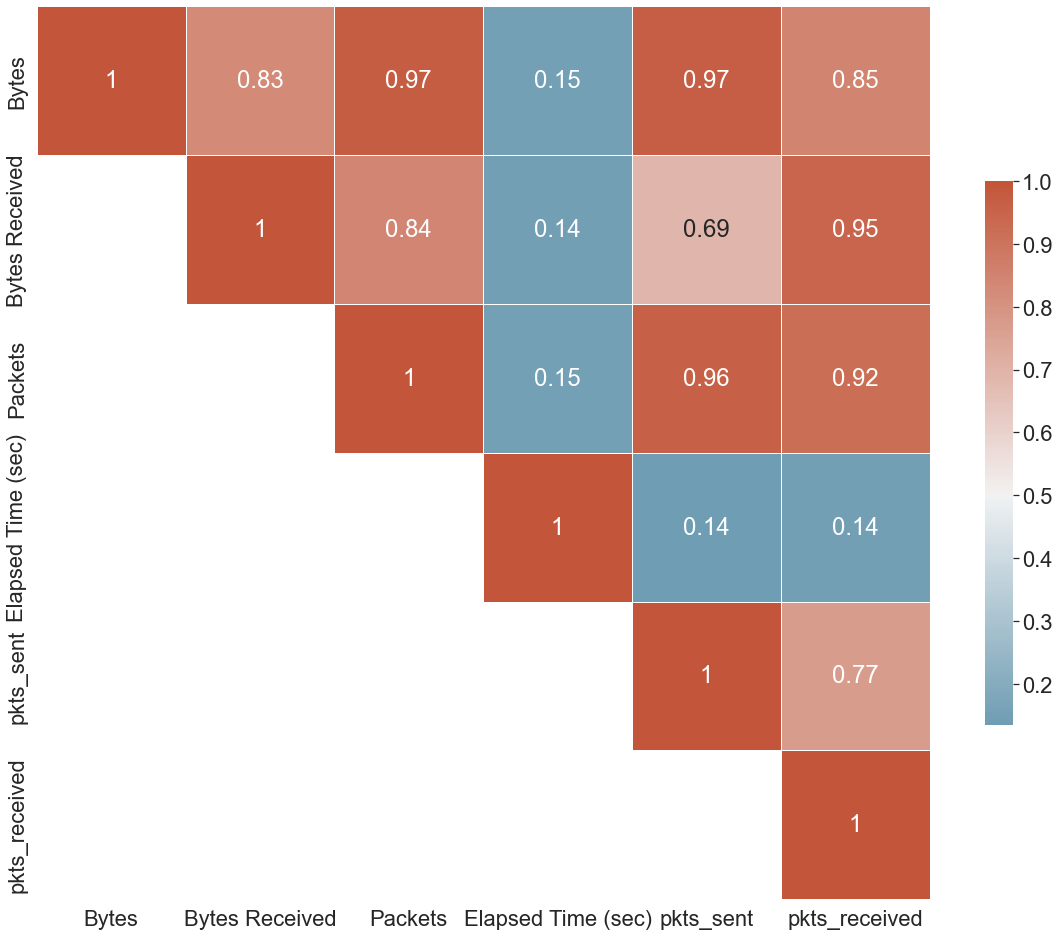

In [43]:
# Check correlation of numeric variables
corr = df_numeric.corr().abs()
upper_tri = corr.where(np.triu(np.ones(corr.shape),k = 0).astype(np.bool))

sns.set(font_scale = 2)
sns.set_style(style = "white")
plt.subplots(figsize = (20,20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(upper_tri, 
            cmap = cmap, 
            vmax = 1, 
            center = 0.5,
            annot = True,
            square = True, 
            linewidths = .5, 
            cbar_kws = {"shrink": .5})

## Test/Train Splits

In [47]:
X, y = df.drop(['Action'], inplace = False, axis = 1), df['Action']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, 
                                                    shuffle = True, 
                                                    random_state = 1, 
                                                    stratify = y
                                                   )

In [48]:
# Define columns to one-hot encode
df_ohe = ['Source Port',
          'Destination Port',
          'NAT Source Port',
          'NAT Destination Port',
          'Source Need NAT',
          'Destination Need NAT']

# Define remaining numeric columns
df_numeric = [names for names in X.columns if names not in df_ohe]

## Helper Functions

In [49]:
# Define cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

# Define cross-validation summary
def cv_summary(estimator, columns):
    df = pd.DataFrame(estimator.cv_results_)
    cv_result_summary = df[columns]
    cv_result_summary.index  = np.arange(1,len(cv_result_summary)+1)
    cv_result_summary = cv_result_summary.reset_index()
    cv_result_summary = cv_result_summary.rename(columns = {
        "index": "param_combination", "mean_test_score": "mean_validation_score",
        "rank_test_score": "rank_validation_score"
    })
    return cv_result_summary

# Define get accuracy score
def get_acc_score(model, x, y):
    """
    Calculates socre from estimator (gridsearch) inherit scorer 
    """
    return model.score(x, y)

# Define get confusion matrix
def get_confusion_matrix(y, yhat,mat_title="Confusion Matrix"):
    x_axis_labels = ['allow','deny','drop']
    y_axis_labels = ['allow','deny','drop']
    cm_n = confusion_matrix(y, yhat)
    ax = sns.heatmap(cm_n,cmap='Blues',annot=True,fmt='2d',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    ax.set_title(mat_title,fontdict={'fontsize':20},pad=15)

# Define get classification report
def get_classification_report(x_train, y_train, x_test, y_test, pred, model):
    """
    This function is used to get comprehensive classification report for binary response:
    Training Accuracy, Test Accuracy, print classification_report, plot confusion matrix.
    """
    print(f"Training Score: {get_acc_score(model, x_train, y_train):,.6f}")
    print("Test result:")
    print(classification_report(y_test,pred,digits=6))
    get_confusion_matrix(y_test,pred)

## Support Vector Classifier Model

In [50]:
params_svc = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__gamma": ["scale", "auto", 1, 0.1, 0.01, 0.001, 0.0001],
    "model__kernel":["linear", "poly", "rbf"],
    "model__class_weight":["balanced"]
}

In [53]:
%time

# Define preprocessing for columns
t = [('cat', OneHotEncoder(handle_unknown='ignore'), df_ohe), 
     ('scale', MinMaxScaler(), df_numeric)]

col_transform = ColumnTransformer(t)

model_svc = SVC()

pipeline_svc = Pipeline(steps=[('preprocessing',col_transform), ('model', model_svc)])

# Fit
clf_svc = RandomizedSearchCV(pipeline_svc, 
                             params_svc, 
                             n_iter = 10, 
                             scoring = 'f1_weighted',
                             random_state = 1, 
                             verbose = 15, 
                             cv = cv, 
                             n_jobs = -1,
                             return_train_score = True)

search_svc = clf_svc.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [55]:
df_search_svc_cv_results_columns = ['param_model__kernel',
                                    'param_model__gamma',
                                    'param_model__class_weight',
                                    'param_model__C',
                                    'mean_train_score',
                                    'mean_test_score',
                                    'rank_test_score']

df_search_svc_cv_results = cv_summary(search_svc, df_search_svc_cv_results_columns)
df_search_svc_cv_results

,param_combination,param_model__kernel,param_model__gamma,param_model__class_weight,param_model__C,mean_train_score,mean_validation_score,rank_validation_score
0,1,linear,0.001,balanced,100,0.998436,0.997253,4
1,2,poly,auto,balanced,0.1,0.068573,0.068577,10
2,3,poly,0.1,balanced,1,0.995976,0.995976,6
3,4,linear,1,balanced,10,0.998436,0.997272,1
4,5,linear,0.0001,balanced,10,0.998436,0.997272,1
5,6,rbf,0.1,balanced,0.1,0.995976,0.995976,6
6,7,rbf,0.01,balanced,100,0.998419,0.997253,3
7,8,poly,0.0001,balanced,100,0.313089,0.313079,9
8,9,rbf,0.1,balanced,100,0.998436,0.997234,5
9,10,linear,scale,balanced,0.1,0.996010,0.995976,6


Training Score: 0.998417
Test result:
              precision    recall  f1-score   support

       allow   0.999334  0.997078  0.998205      7528
        deny   0.992027  0.995997  0.994008      2998
        drop   0.997282  0.999222  0.998251      2570

    accuracy                       0.997251     13096
   macro avg   0.996214  0.997432  0.996821     13096
weighted avg   0.997259  0.997251  0.997253     13096



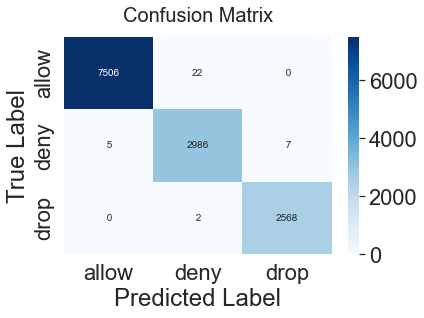

In [56]:
predict = search_svc.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, predict, search_svc)

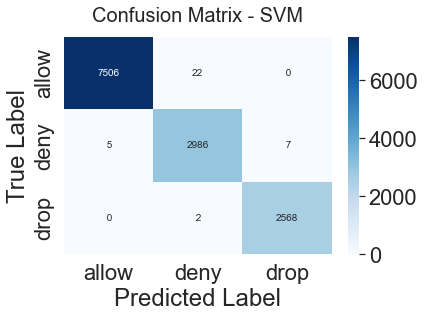

[CV 7/10; 1/10] START model__C=100, model__class_weight=balanced, model__gamma=0.001, model__kernel=linear
[CV 7/10; 1/10] END model__C=100, model__class_weight=balanced, model__gamma=0.001, model__kernel=linear;, score=(train=0.998, test=0.998) total time= 2.3min
[CV 1/10; 3/10] START model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly
[CV 1/10; 3/10] END model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly;, score=(train=0.996, test=0.997) total time= 2.9min
[CV 7/10; 3/10] START model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly
[CV 7/10; 3/10] END model__C=1, model__class_weight=balanced, model__gamma=0.1, model__kernel=poly;, score=(train=0.996, test=0.997) total time= 2.7min
[CV 5/10; 4/10] START model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear
[CV 5/10; 4/10] END model__C=10, model__class_weight=balanced, model__gamma=1, model__kernel=linear;, score=(train=0.998, test=

In [57]:
get_confusion_matrix(y_test, predict,mat_title="Confusion Matrix - SVM" )

In [60]:
file_name_svc = "search_svc_model.sav"
search_svc = joblib.load(file_name_svc)

FileNotFoundError: [Errno 2] No such file or directory: 'search_svc_model.sav'

### SGD Classifier

In [61]:
params_sgd = [
    # optimal learning rate
    {
        "model__learning_rate": ["optimal"],
        "model__alpha": [0.000001, 0.00001, 0.0001, 0.001, 0.01],
        "model__eta0": [0],
        "model__class_weight":["balanced"]
    },
    # constant learning rate (eta0 cannot be 0 for this)
    {
    "model__learning_rate": ["constant"],
    "model__alpha": [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    "model__eta0": [0.01, 0.1, 1.0, 5, 10],
    "model__class_weight":["balanced"]
    }
]

In [63]:
%%time

# define preprocessing for columns
t = [('cat', OneHotEncoder(handle_unknown='ignore'), df_ohe), 
     ('scale', MinMaxScaler(), df_numeric)]

col_transform = ColumnTransformer(t)

model_sgd = SGDClassifier(loss = 'log')

pipeline_sgd = Pipeline(steps=[('preprocessing',col_transform), ('model', model_sgd)])

#Fit
clf_sgd = GridSearchCV(pipeline_sgd, 
                       params_sgd, 
                       scoring = 'f1_weighted',
                       verbose = 15, 
                       cv = cv, 
                       n_jobs = -1,
                       return_train_score = True)

search_sgd = clf_sgd.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was

CPU times: user 3.89 s, sys: 1.43 s, total: 5.33 s
Wall time: 27.1 s


In [64]:
df_search_sgd_cv_results_columns = ['param_model__alpha',
                                    'param_model__eta0',
                                    'param_model__learning_rate',
                                    'mean_train_score',
                                    'mean_test_score',
                                    'rank_test_score']

df_search_sgd_cv_results = cv_summary(search_sgd, df_search_sgd_cv_results_columns)
df_search_sgd_cv_results

,param_combination,param_model__alpha,param_model__eta0,param_model__learning_rate,mean_train_score,mean_validation_score,rank_validation_score
0,1,0.000001,0,optimal,0.998451,0.997250,1
1,2,0.00001,0,optimal,0.997166,0.996432,5
2,3,0.0001,0,optimal,0.995976,0.995976,8
3,4,0.001,0,optimal,0.990522,0.990523,20
4,5,0.01,0,optimal,0.990522,0.990523,20
5,6,0.000001,0.01,constant,0.995976,0.995976,8
6,7,0.000001,0.1,constant,0.996919,0.996565,4
7,8,0.000001,1.0,constant,0.998033,0.996928,3
8,9,0.000001,5,constant,0.997799,0.997023,2
9,10,0.000001,10,constant,0.996506,0.995732,13


In [65]:
df_search_sgd_cv_results_columns = ["param_model__alpha",
                                    "param_model__eta0",
                                    "param_model__learning_rate",
                                    "mean_train_score",
                                    "mean_test_score",
                                    "rank_test_score"]

df_search_sgd_cv_results = cv_summary(search_sgd, df_search_sgd_cv_results_columns)
df_search_sgd_cv_results

,param_combination,param_model__alpha,param_model__eta0,param_model__learning_rate,mean_train_score,mean_validation_score,rank_validation_score
0,1,0.000001,0,optimal,0.998451,0.997250,1
1,2,0.00001,0,optimal,0.997166,0.996432,5
2,3,0.0001,0,optimal,0.995976,0.995976,8
3,4,0.001,0,optimal,0.990522,0.990523,20
4,5,0.01,0,optimal,0.990522,0.990523,20
5,6,0.000001,0.01,constant,0.995976,0.995976,8
6,7,0.000001,0.1,constant,0.996919,0.996565,4
7,8,0.000001,1.0,constant,0.998033,0.996928,3
8,9,0.000001,5,constant,0.997799,0.997023,2
9,10,0.000001,10,constant,0.996506,0.995732,13


Training Score: 0.998417
Test result:
              precision    recall  f1-score   support

       allow   0.999334  0.996679  0.998005      7528
        deny   0.991039  0.995997  0.993512      2998
        drop   0.997282  0.999222  0.998251      2570

    accuracy                       0.997022     13096
   macro avg   0.995885  0.997299  0.996589     13096
weighted avg   0.997032  0.997022  0.997025     13096



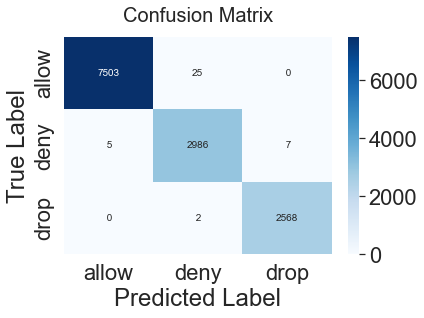

In [66]:
predict_sgd = search_sgd.predict(X_test)
get_classification_report(X_train, y_train, X_test, y_test, predict_sgd, search_sgd)

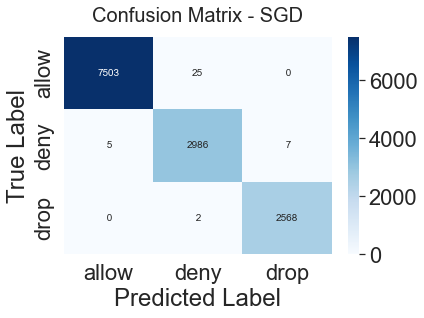

In [67]:
get_confusion_matrix(y_test, predict_sgd, mat_title="Confusion Matrix - SGD" )

In [68]:
file_name_sgd = "search_sgd_model.sav"
search_sgd = joblib.load(file_name_sgd)

FileNotFoundError: [Errno 2] No such file or directory: 'search_sgd_model.sav'

[CV 3/10; 1/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 3/10; 1/30] END model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.998, test=0.998) total time=   1.4s
[CV 5/10; 3/30] START model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 5/10; 3/30] END model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.996, test=0.996) total time=   0.8s
[CV 10/10; 4/30] START model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 10/10; 4/30] END model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.991, test=0.990) total time=   0.7s
[CV 9/10; 6/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0.01, model__learning_rate=constant
[CV 9/10; 6/30] END model__

[CV 1/10; 2/30] START model__alpha=1e-05, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 1/10; 2/30] END model__alpha=1e-05, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.997, test=0.998) total time=   1.0s
[CV 8/10; 2/30] START model__alpha=1e-05, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 8/10; 2/30] END model__alpha=1e-05, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.998, test=0.996) total time=   0.7s
[CV 2/10; 4/30] START model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 2/10; 4/30] END model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.990, test=0.992) total time=   0.6s
[CV 7/10; 5/30] START model__alpha=0.01, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 7/10; 5/30] END model__alpha=0.0

[CV 9/10; 1/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 9/10; 1/30] END model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.998, test=0.996) total time=   1.3s
[CV 2/10; 3/30] START model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 2/10; 3/30] END model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.996, test=0.996) total time=   0.8s
[CV 6/10; 4/30] START model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 6/10; 4/30] END model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.991, test=0.990) total time=   0.8s
[CV 2/10; 6/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0.01, model__learning_rate=constant
[CV 2/10; 6/30] END model__al

[CV 5/10; 1/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 5/10; 1/30] END model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.999, test=0.998) total time=   1.4s
[CV 6/10; 3/30] START model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 6/10; 3/30] END model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.996, test=0.996) total time=   0.7s
[CV 2/10; 5/30] START model__alpha=0.01, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 2/10; 5/30] END model__alpha=0.01, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.990, test=0.992) total time=   0.7s
[CV 4/10; 6/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0.01, model__learning_rate=constant
[CV 4/10; 6/30] END model__alph

[CV 10/10; 1/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 10/10; 1/30] END model__alpha=1e-06, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.998, test=0.998) total time=   1.3s
[CV 3/10; 3/30] START model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 3/10; 3/30] END model__alpha=0.0001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.996, test=0.995) total time=   0.8s
[CV 8/10; 4/30] START model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal
[CV 8/10; 4/30] END model__alpha=0.001, model__class_weight=balanced, model__eta0=0, model__learning_rate=optimal;, score=(train=0.990, test=0.992) total time=   0.7s
[CV 1/10; 6/30] START model__alpha=1e-06, model__class_weight=balanced, model__eta0=0.01, model__learning_rate=constant
[CV 1/10; 6/30] END model__